In [ ]:
%cd /content/
!rm -rf /content/Whats-this-rock/
# !git clone https://github.com/udaylunawat/Whats-this-rock.git
!git clone -b nbdev https://github.com/udaylunawat/Whats-this-rock.git

/content
Cloning into 'Whats-this-rock'...
remote: Enumerating objects: 2989, done.
remote: Counting objects: 100% (1229/1229), done.
remote: Compressing objects: 100% (609/609), done.
remote: Total 2989 (delta 692), reused 979 (delta 603), pack-reused 1760
Receiving objects: 100% (2989/2989), 10.77 MiB | 20.23 MiB/s, done.
Resolving deltas: 100% (1895/1895), done.


In [ ]:
%cd /content/Whats-this-rock/

/content/Whats-this-rock


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!sh src/scripts/setup.sh

libcudnn8 is already the newest version (8.1.1.33-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Whats-this-rock (from -r requirements-dev.txt (line 1))
     |████████████████████████████████| 1.1 MB 6.9 MB/s 
     |████████████████████████████████| 394 kB 52.2 MB/s 
     |████████████████████████████████| 1.9 MB 40.3 MB/s 
     |████████████████████████████████| 151 kB 31.8 MB/s 
     |████████████████████████████████| 63 kB 612 kB/s 
     |████████████████████████████████| 166 kB 56.1 MB/s 
     |████████████████████████████████| 182 kB 72.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 55.8 MB/s 
     |████████████████████████████████| 1

# fast.ai code

## Downloading data and moving bad, corrupted and duplicate images

### Downloading data

In [ ]:
!rm -rf data/bad_images/

In [ ]:
import omegaconf
import subprocess
from src.data.download import get_data
from src.data.preprocess import process_data

cfg = omegaconf.OmegaConf.load('configs/config.yaml')
cfg.dataset_id = [1,2,3,4]

subprocess.run(["sh", "src/scripts/clean_dir.sh"], stdout=subprocess.PIPE).stdout.decode("utf-8")
for dataset_id in cfg.dataset_id:
    get_data(dataset_id)
process_data(cfg)

Function 'get_data' executed in 6.0900s
Function 'get_data' executed in 13.1854s
Function 'get_data' executed in 1.5412s
Function 'get_data' executed in 14.0627s

Processing dataset3


Moving Quartzite: 100%|██████████| 64/64 [00:00<00:00, 6057.03it/s]



Processing dataset2


Moving granite: 100%|██████████| 113/113 [00:00<00:00, 4581.94it/s]



Processing dataset4

Processing dataset1


Moving Granite: 100%|██████████| 101/101 [00:00<00:00, 1758.72it/s]



Files other than jpg and png.


data/2_processed:
Basalt
Coal
Granite
Limestone
Marble
Quartzite
Sandstone

data/2_processed/Basalt:

data/2_processed/Coal:
Coal_112.jpeg
Coal_148.jpeg
Coal_158.jpeg
Coal_250.jpeg
Coal_258.jpeg
Coal_275.jpeg
Coal_279.jpeg
Coal_303.jpeg
Coal_304.jpeg
Coal_311.jpeg
Coal_314.jpeg
Coal_355.jpeg
Coal_375.jpeg
Coal_391.jpeg
Coal_405.jpeg
Coal_407.jpeg
Coal_411.jpeg
Coal_430.jpeg
Coal_450.jpeg
Coal_452.jpeg
Coal_458.jpeg

data/2_processed/Granite:
Granite_181.JPEG
Granite_184.JPEG
Granite_188.JPEG
Granite_189.JPEG
Granite_194.JPEG
Granite_198.JPEG
Granite_200.JPEG
Granite_204.JPEG
Granite_210.JPEG
Granite_218.jpeg
Granite_228.JPEG
Granite_239.JPEG
Granite_241.JPEG
Granite_243.JPEG
Granite_244.JPEG
Granite_249.JPEG
Granite_253.JPEG
Granite_257.JPEG
Granite_258.JPEG
Granite_260.jpeg
Granite_273.JPEG
Granite_279.JPEG

data/2_processed/Limestone:
Limestone_276.jpeg
Limestone_293.webp
Limestone_297.jfif
Limestone_308.jfif
Limestone_351.jpeg
Limestone_355.jfif
Lime

Copying files: 3004 files [00:00, 3866.19 files/s]

### Remove duplicate images

In [ ]:
# https://github.com/saifjamsheer/google-dataset-creator/tree/c458ec1f2e676f474527cbf3ee2da3937d260d0c
from imutils import paths
from pathlib import Path
import os
import cv2
import argparse

"""
Script that deletes duplicate images from a dataset. This
can be used in conjunction with 'create.py' to delete
any duplicate images before manual pruning is done. 
"""
def dhash(image, hashSize=8):
    # Convert the image to grayscale and resize it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    # Compute the horizontal gradient between adjacent pixels
    diff = resized[:, 1:] > resized[:, :-1]
    # Converts the image to a hash and returns it
    hash = sum([2**i for (i,j) in enumerate(diff.flatten()) if j])
    return hash

def remove_duplicates(dir):
    # Path of the dataset of images
    output_path = dir
    hashes = dict()

    # List of paths of the images in the datasets
    image_paths = list(paths.list_images(output_path))

    for image_path in image_paths:
        # Load input image
        
        image = cv2.imread(image_path)
        # Compute the hash of the image
        try:
            h = dhash(image)
        except:
            print(f'cv2.imread {image_path} Returns None!')
        # Store all images in a dictionary of hashes
        path = hashes.get(h, [])
        path.append(image_path)
        hashes[h] = path

    # Iterate through the hashes
    for h, path_value in hashes.items():
        # Checking if a duplicate exists
        if len(path_value) > 1:
            # Deleting all duplicates
            for path in path_value[1:]:
                print("[INFO] Deleting: {}".format(path))
                os.remove(path)

In [ ]:
for classname in os.listdir('data/2_processed'):
    class_path = os.path.join('data/2_processed', classname)
    print(f"Processing:- {classname}")
    remove_duplicates(class_path)

Processing:- Limestone
[INFO] Deleting: data/2_processed/Limestone/Limestone_354.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_116.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_6.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_23.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_129.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_403.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_11.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_74.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_71.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_19.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_234.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_361.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_334.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_18.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_66.jpg
[INFO] Deleting: data/2_processed/Limestone/Limestone_37

### Removing bad images

In [ ]:
# Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(names, filename='delfile'):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(names, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(filename='delfile'):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

# del_list = read_list()
# print('List is', del_list)

In [ ]:
bad_images = read_list('updated_delete_pickle')

In [ ]:
import os
import shutil
os.makedirs('data/bad_images', exist_ok=True)

for path in bad_images:
    if os.path.exists(path):
        shutil.move(str(path), 'data/bad_images')

In [ ]:
# assert len(os.listdir('data/bad_images')) == len(bad_images)

## Loading data

In [ ]:
from fastai.vision.all import *

In [ ]:
dls = ImageDataLoaders.from_folder(path='data/2_processed/', valid_pct=0.2,
                                   item_tfms=Resize(224))
dls.valid_ds.items[:3]

[Path('data/2_processed/Quartzite/Quartzite_242.jpg'),
 Path('data/2_processed/Basalt/Basalt_63.jpg'),
 Path('data/2_processed/Granite/Granite_9.jpg')]

In [ ]:
print(f'Training set samples:- {len(dls.train_ds)} images.\nValidation set samples:- {len(dls.valid_ds)} images.')

Training set samples:- 2185 images.
Validation set samples:- 546 images.


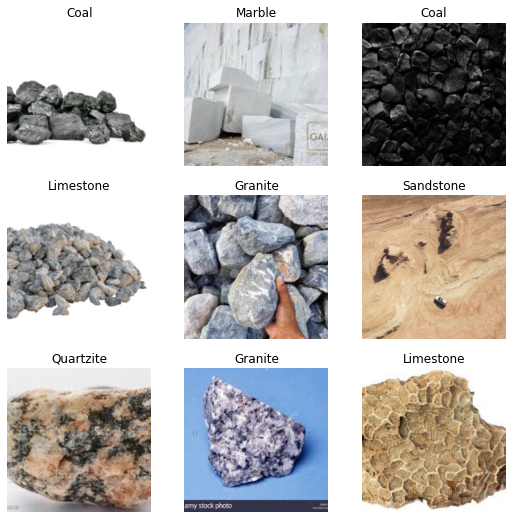

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, F1Score(average='macro')])


In [ ]:
learn.fine_tune(5, cbs=ShowGraphCallback())

Lowest error rate:- 0.2460, val_loss:- 0.93

In [ ]:
# save model
learn.export(file='model.pkl')

learn = load_learner('model.pkl')

In [ ]:
learn.predict('data/4_tfds_dataset/test/Basalt/Basalt_104.jpg')

In [ ]:
def get_results(learn):
    print(f'\nSample Results:')
    learn.show_results()
    plt.show()

    interp = Interpretation.from_learner(learn)
    print(f'\nTop losses:-')
    interp.plot_top_losses(9, figsize=(15,10))
    plt.show()

    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(dls.valid_ds)==len(losses)==len(idxs)

    print(f'\nConfusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7))
    plt.show()

    print(f'\nNormalized Confusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7), normalize=True)
    plt.show()


In [ ]:
get_results(learn)

## Data Cleaning

### Remove bad images

In [ ]:
files_to_delete = []

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): files_to_delete.append(cleaner.fns[idx])

In [ ]:
def tfds_to_processed(filepath):
    base = '/'.join(str(filepath).split('/')[-2:]).replace('\')','')
    processed = os.path.join('data/2_processed', base)
    return Path(set(processed))

new_paths = list(map(lambda x:tfds_to_processed(x), files_to_delete))

In [ ]:
# update delfile
paths = read_list()
write_list(paths+new_paths, 'delete_file_pickle')

In [ ]:
latest_del = paths+new_paths

In [ ]:
try: 
    for idx in paths:
        idx.unlink()
except: pass

write_list(paths, filename='delfile')

In [ ]:
!rm -rf data/4_tfds_dataset

In [ ]:
import splitfolders
splitfolders.ratio(
            "data/2_processed",
            output="data/4_tfds_dataset",
            ratio=(0.70, 0.15, 0.15),
            seed=42,
            move=False,
        )

Training after data cleaning

In [ ]:
dls = ImageDataLoaders.from_folder(path='data/4_tfds_dataset/',
                                   train='train',
                                   valid='val',
                                   item_tfms=Resize(224))
dls.valid_ds.items[:3]

In [ ]:
print(f"Number of images after deletetion:- ")
print(f'Training set samples:- {len(dls.train_ds)} images.\nValidation set samples:- {len(dls.valid_ds)} images.')

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, cbs=ShowGraphCallback())

## Using fastai Data Augmentation

In [ ]:
dls = ImageDataLoaders.from_folder(path='data/4_tfds_dataset/', train='train',
                                   valid='val', item_tfms=Resize(460),
                                   batch_tfms=aug_transforms(size=224))
dls.valid_ds.items[:3]

[Path('data/4_tfds_dataset/val/Limestone/Limestone_33.jpg'),
 Path('data/4_tfds_dataset/val/Limestone/Limestone_417.jpg'),
 Path('data/4_tfds_dataset/val/Limestone/Limestone_285.jpg')]

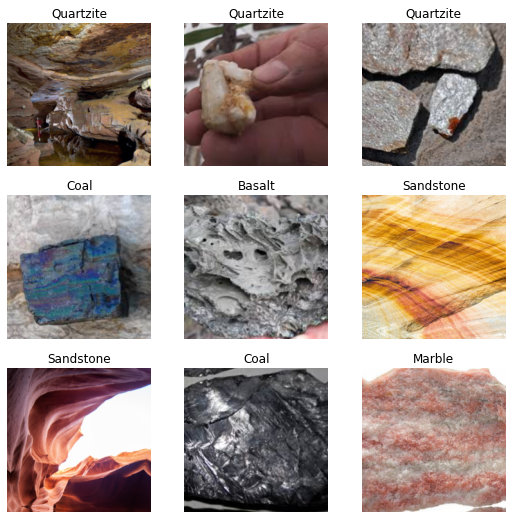

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.lr_find()

Using optimal lr

In [ ]:
learn.fine_tune(5, 3e-3)

In [ ]:
get_results(learn)